In [8]:
from torch.utils.data import Dataset 
from PIL import Image

class ImageDataset(Dataset):
  def __init__(self,dataframe , transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.label_map = {'Covid':0 , 'Normal':1,'Viral Pneumonia':2}
  def __len__(self):
    return len(self.dataframe)

  def __getitem__(self,idx):
    image_path = self.dataframe.iloc[idx,0]
    label = self.label_map[self.dataframe.iloc[idx,1]]
    image = Image.open(image_path).convert('RGB')
    if self.transform:
      image = self.transform(image)
    return image,label


In [9]:
from torchvision import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset , DataLoader
from torchvision import transforms
import pandas as pd



train_dataset = torch.load('C:/Users/Public/pycharm/CNN-Model-covid-19/Data/train_dataset.pth')
test_dataset = torch.load('C:/Users/Public/pycharm/CNN-Model-covid-19/Data/train_dataset.pth')

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = models.mobilenet_v2(pretrained=True)

# Изменяем классификатор под 3 класса + добавляем Dropout
num_classes = 3
model.classifier = nn.Sequential(
    nn.Dropout(0.3),  # Добавили Dropout для борьбы с переобучением
    nn.Linear(model.last_channel, num_classes)
)

# Переносим модель на GPU/CPU
model = model.to(device)

# Замораживаем веса всех слоев, кроме классификатора
for param in model.features.parameters():
    param.requires_grad = False

# Функция потерь и оптимизатор
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Добавляем lr_scheduler для плавного уменьшения learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

# Аугментация для обучения (усилили)
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Кроп с изменением масштаба
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.GaussianBlur(kernel_size=(3, 3)),  # Добавили размытие
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Аугментация для валидации (без изменений)
transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Создаем DataLoader'ы с shuffle=True для обучения
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Тренировка модели
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss, train_correct = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()

    train_accuracy = train_correct / len(train_dataset)

    # Валидация
    model.eval()
    val_loss, val_correct = 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_correct += (outputs.argmax(1) == labels).sum().item()

    val_accuracy = val_correct / len(test_dataset)

    # Обновляем lr_scheduler
    scheduler.step()

    print(f"Epoch {epoch + 1}: Train Acc: {train_accuracy:.2f}, Val Acc: {val_accuracy:.2f}")



C:\Users\igork\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\igork\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc: 0.53, Val Acc: 0.70
Epoch 2: Train Acc: 0.81, Val Acc: 0.73
Epoch 3: Train Acc: 0.83, Val Acc: 0.61
Epoch 4: Train Acc: 0.88, Val Acc: 0.74
Epoch 5: Train Acc: 0.90, Val Acc: 0.77
Epoch 6: Train Acc: 0.90, Val Acc: 0.80
Epoch 7: Train Acc: 0.88, Val Acc: 0.88
Epoch 8: Train Acc: 0.90, Val Acc: 0.88
Epoch 9: Train Acc: 0.94, Val Acc: 0.85
Epoch 10: Train Acc: 0.93, Val Acc: 0.86


In [12]:
model.eval()
correct = 0
total = 0
true_labels = []
predicted_labels = []

with torch.no_grad():
  for images,labels in test_loader:
    images,labels = images.to(device),labels.to(device)
    outputs = model(images)
    _,predicted = torch.max(outputs.data,1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(predicted.cpu().numpy())
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 86.36%


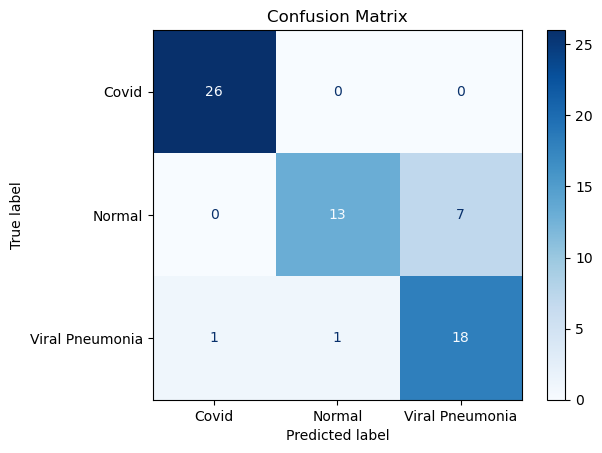

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

class_names = ['Covid', 'Normal', 'Viral Pneumonia']
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

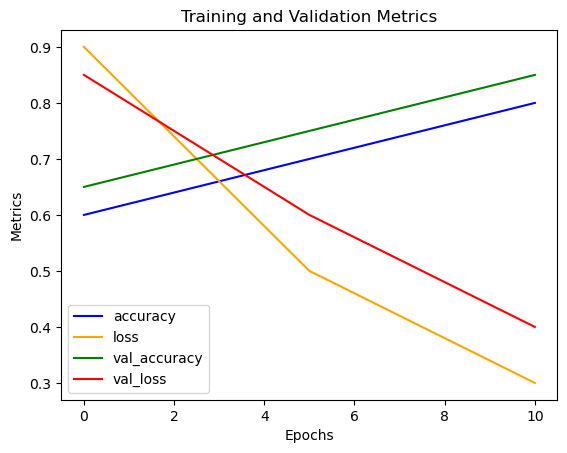

In [16]:
import matplotlib.pyplot as plt

epochs = [0,5,10]

accuracy = [0.6, 0.7, 0.8]
loss = [0.9, 0.5, 0.3]
val_accuracy = [0.65, 0.75, 0.85]
val_loss = [0.85, 0.6, 0.4]

plt.plot(epochs, accuracy, label="accuracy", color="blue")
plt.plot(epochs, loss, label="loss", color="orange")
plt.plot(epochs, val_accuracy, label="val_accuracy", color="green")
plt.plot(epochs, val_loss, label="val_loss", color="red")

plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.legend()
plt.title("Training and Validation Metrics")
plt.show()

# One-vs-Rest (OvR)

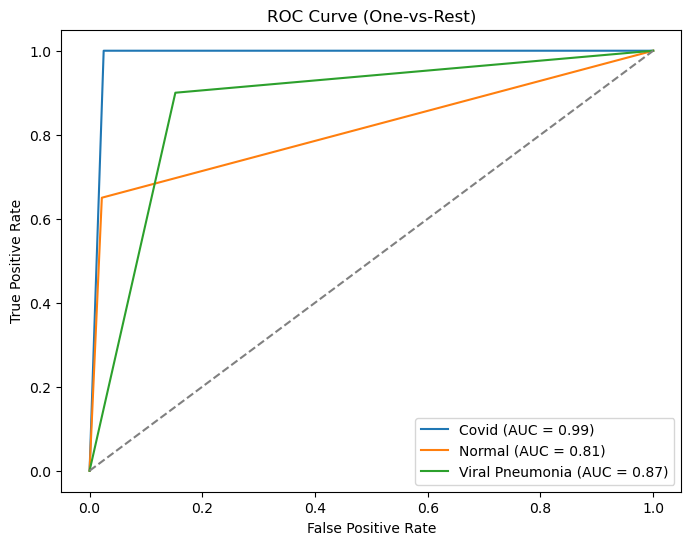

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Допустим, у тебя 3 класса:
class_names = ['Covid', 'Normal', 'Viral Pneumonia']

# Преобразуем метки в формат One-vs-Rest
y_true_bin = label_binarize(true_labels, classes=[0, 1, 2])
y_pred_bin = label_binarize(predicted_labels, classes=[0, 1, 2])

plt.figure(figsize=(8, 6))

for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    auc_score = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{class_names[i]} (AUC = {auc_score:.2f})')

# Линия случайного угадывания
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest)')
plt.legend()
plt.show()


Cohen's Kappa Score

In [18]:
from sklearn.metrics import cohen_kappa_score

kappa_1 = cohen_kappa_score(true_labels, predicted_labels)
print(f"Model 1 Cohen's Kappa: {kappa_1:.4f}")


Model 1 Cohen's Kappa: 0.7933


# Classification Report

In [19]:
from sklearn.metrics import classification_report

print("Model 1:")
print(classification_report(true_labels, predicted_labels, target_names=class_names))

Model 1:
                 precision    recall  f1-score   support

          Covid       0.96      1.00      0.98        26
         Normal       0.93      0.65      0.76        20
Viral Pneumonia       0.72      0.90      0.80        20

       accuracy                           0.86        66
      macro avg       0.87      0.85      0.85        66
   weighted avg       0.88      0.86      0.86        66



# Results

In [21]:
import pandas as pd
accuracy = [accuracy] * len(true_labels)
results = {
    'true_labels': true_labels,
    'predicted_labels': predicted_labels,
    'accuracy': accuracy,
}

df = pd.DataFrame(results)
df.to_csv('results_mobilnet.csv', index=False)